# Introduction

After completing the first task, the client implemented the suggested market strategies to three trial stores: 77, 86, and 88. The client has asked us to test the impact of the new trial layouts with a data driven recommendation to whether or not the trial layout should be rolled out to other stores. 

In this analysis, I will be selecting control stores for each trial store and compare their performance. Here are some of the goals for this analysis:
- Select control stores - explore data and define metrics for control store. Look at the drivers and look at them visually to see if they are suitable
- Assess each trial store - Look at each of the trial store and compare them to the control store to see if there are significant difference

In [2]:
#Import
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Date
from datetime import datetime

#Warnings
import warnings
warnings.filterwarnings('ignore')

#Statistics
from scipy.stats import pearsonr

#Regular Expression
import re

#Apriori
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

#Others
from collections import Counter

In [3]:
#Import dataset
data = pd.read_csv("QVI_data.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [5]:
data.describe()

,LYLTY_CARD_NBR,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE
count,2.648340e+05,264834.000000,2.648340e+05,264834.000000,264834.000000,264834.000000,264834.000000
mean,1.355488e+05,135.079423,1.351576e+05,56.583554,1.905813,7.299346,182.425512
std,8.057990e+04,76.784063,7.813292e+04,32.826444,0.343436,2.527241,64.325148
min,1.000000e+03,1.000000,1.000000e+00,1.000000,1.000000,1.500000,70.000000
25%,7.002100e+04,70.000000,6.760050e+04,28.000000,2.000000,5.400000,150.000000
50%,1.303570e+05,130.000000,1.351365e+05,56.000000,2.000000,7.400000,170.000000
75%,2.030940e+05,203.000000,2.026998e+05,85.000000,2.000000,9.200000,175.000000
max,2.373711e+06,272.000000,2.415841e+06,114.000000,5.000000,29.500000,380.000000


In [6]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


# Selecting Control Stores
The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.

We want to select a store that match trial stores similar to a store before Feb 2019 in terms of:
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's start by creating the metrics and filtering the data present to the pre-trial period.

In [7]:
#We will start by creating a Month ID
data["DATE"] = pd.to_datetime(data["DATE"])
data["Month_ID"] = data["DATE"].dt.to_period('M')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,Month_ID
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


For each store and month we will calculate total sales, number of customers, transactions per customer, chips per customer and the average price per unit.

In [8]:
#Create a new dataframe to store metrics
data_metrics = pd.DataFrame()

#Number of customers
data_metrics["num_customer"] = data.groupby(["STORE_NBR", "Month_ID"]).agg("count")["LYLTY_CARD_NBR"]
data_metrics["num_customer"]

STORE_NBR  Month_ID
1          2018-07     52
           2018-08     43
           2018-09     62
           2018-10     45
           2018-11     47
                       ..
272        2019-02     48
           2019-03     53
           2019-04     56
           2019-05     40
           2019-06     37
Name: num_customer, Length: 3169, dtype: int64

In [9]:
#Total Sales
data_metrics["tot_sales"] = data.groupby(["STORE_NBR", "Month_ID"]).agg("sum")["TOT_SALES"]
data_metrics["tot_sales"]

STORE_NBR  Month_ID
1          2018-07     206.9
           2018-08     176.1
           2018-09     278.8
           2018-10     188.1
           2018-11     192.6
                       ...  
272        2019-02     395.5
           2019-03     442.3
           2019-04     445.1
           2019-05     314.6
           2019-06     312.1
Name: tot_sales, Length: 3169, dtype: float64

In [10]:
#Average transactions
data_metrics["avg_transaction"] = data.groupby(["STORE_NBR", "Month_ID", "LYLTY_CARD_NBR"]).agg(["count"]).groupby(["STORE_NBR", "Month_ID"]).agg("mean")["DATE"]
data_metrics["avg_transaction"]

STORE_NBR  Month_ID
1          2018-07     1.061224
           2018-08     1.023810
           2018-09     1.050847
           2018-10     1.022727
           2018-11     1.021739
                         ...   
272        2019-02     1.066667
           2019-03     1.060000
           2019-04     1.037037
           2019-05     1.176471
           2019-06     1.088235
Name: avg_transaction, Length: 3169, dtype: float64

In [11]:
#Average chips
data_metrics["avg_chips"] = data.groupby(["STORE_NBR", "Month_ID", "LYLTY_CARD_NBR"]).agg(["mean"]).groupby(["STORE_NBR", "Month_ID"]).agg("mean")["PROD_QTY"]
data_metrics["avg_chips"]

STORE_NBR  Month_ID
1          2018-07     1.183673
           2018-08     1.261905
           2018-09     1.211864
           2018-10     1.295455
           2018-11     1.206522
                         ...   
272        2019-02     1.903704
           2019-03     1.910000
           2019-04     1.879630
           2019-05     1.779412
           2019-06     1.911765
Name: avg_chips, Length: 3169, dtype: float64

In [12]:
#Average price per unit
data_temp = data[["STORE_NBR", "LYLTY_CARD_NBR", "Month_ID", "PROD_QTY", "TOT_SALES"]]
data_temp["price_per_quantity"] = data_temp["TOT_SALES"]/data_temp["PROD_QTY"]
data_metrics["avg_price_per_quantity"] = data_temp.groupby(["STORE_NBR", "Month_ID"]).agg("mean")["price_per_quantity"]
data_metrics["avg_price_per_quantity"]

STORE_NBR  Month_ID
1          2018-07     3.384615
           2018-08     3.329070
           2018-09     3.685484
           2018-10     3.288889
           2018-11     3.412766
                         ...   
272        2019-02     4.358333
           2019-03     4.350943
           2019-04     4.248214
           2019-05     4.437500
           2019-06     4.424324
Name: avg_price_per_quantity, Length: 3169, dtype: float64

In [13]:
data_metrics = data_metrics.reset_index(level=['STORE_NBR', 'Month_ID'])

In [14]:
data_counts = data_metrics.groupby("STORE_NBR").agg("count")["Month_ID"]
store_list = data_counts[data_counts == 12].index.to_list()
data_metrics_fs = data_metrics[data_metrics["STORE_NBR"].isin(store_list)]
data_metrics_fs

,STORE_NBR,Month_ID,num_customer,tot_sales,avg_transaction,avg_chips,avg_price_per_quantity
0,1,2018-07,52,206.9,1.061224,1.183673,3.384615
1,1,2018-08,43,176.1,1.023810,1.261905,3.329070
2,1,2018-09,62,278.8,1.050847,1.211864,3.685484
3,1,2018-10,45,188.1,1.022727,1.295455,3.288889
4,1,2018-11,47,192.6,1.021739,1.206522,3.412766
...,...,...,...,...,...,...,...
3164,272,2019-02,48,395.5,1.066667,1.903704,4.358333
3165,272,2019-03,53,442.3,1.060000,1.910000,4.350943
3166,272,2019-04,56,445.1,1.037037,1.879630,4.248214
3167,272,2019-05,40,314.6,1.176471,1.779412,4.437500


In [15]:
data_metrics_fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3120 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype    
---  ------                  --------------  -----    
 0   STORE_NBR               3120 non-null   int64    
 1   Month_ID                3120 non-null   period[M]
 2   num_customer            3120 non-null   int64    
 3   tot_sales               3120 non-null   float64  
 4   avg_transaction         3120 non-null   float64  
 5   avg_chips               3120 non-null   float64  
 6   avg_price_per_quantity  3120 non-null   float64  
dtypes: float64(4), int64(2), period[M](1)
memory usage: 195.0 KB


In [16]:
#Now we filter only values before Febuary 2019 (Pre-trial period)
data_metrics_pre = data_metrics_fs[data_metrics_fs["Month_ID"] < "2019-02"]
data_metrics_pre["Month_ID"].unique()

<PeriodArray>
['2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01']
Length: 7, dtype: period[M]

Next, we will create a function to calculate the correlation between the trial store and the control store.

In [17]:
def CalculateCorrelation(input_table, metric_col, store_comparison):
    store_numbers = input_table["STORE_NBR"].unique()
    coorList = []
    for i in store_numbers:
        store_numbers = input_table["STORE_NBR"].unique()
        store_1 = store_comparison
        store_2 = i
        store_trial = input_table[input_table["STORE_NBR"] == store_1][metric_col]
        store_control = input_table[input_table["STORE_NBR"] == store_2][metric_col]
        coor_measure = pearsonr(store_trial, store_control)[0]
        coorList.append([store_1, store_2, coor_measure])
    correlationTable = pd.DataFrame(coorList, columns=["STORE1", "STORE2", "COORMEASURE"])
    return correlationTable

Aside from correlation, we can also calculate a standardized metric based on the absolute difference between the trial store's performance and each control store's performance.

In [18]:
def CalculateMagnitudeDistance (input_table, metric_col, store_comparison):
    # Find abs value between trial and control
    # standardize
    distdf = pd.DataFrame()
    store_numbers = data_metrics_pre["STORE_NBR"].unique()
    data_list = []

    for i in store_numbers:
        store_1 = store_comparison
        store_2 = i
        grouped_metrics = input_table.groupby(["Month_ID", "STORE_NBR"]).agg("sum")[metric_col]
        grouped_metrics = grouped_metrics.reset_index(level="STORE_NBR")
        measure = np.abs(grouped_metrics[grouped_metrics["STORE_NBR"] == store_1][metric_col] - grouped_metrics[grouped_metrics["STORE_NBR"] == store_2][metric_col])
        measure = measure.reset_index()
        measure["STORE1"] = store_1
        measure["STORE2"] = store_2
        distdf = pd.concat([measure, distdf], axis=0)
    #Reset distdf index
    distdf = distdf.reset_index(drop=True)

    #Standardize the values
    grouped_table = distdf.groupby(["STORE1", "Month_ID"]).agg(["max", "min"])[metric_col]
    grouped_table = grouped_table.reset_index()

    #Change Month-ID to string so we can use df.merge()
    distdf["YEARMONTH"] = distdf["Month_ID"].astype(str).str.replace('-','')
    distdf = distdf.drop("Month_ID", axis=1)
    grouped_table["YEARMONTH"] = grouped_table["Month_ID"].astype(str).str.replace('-','')
    grouped_table = grouped_table.drop("Month_ID", axis=1)

    distdf = distdf.merge(grouped_table, on=["STORE1", "YEARMONTH"])
    distdf[metric_col] = 1-((distdf[metric_col] - distdf["min"])/(distdf["max"] - distdf["min"]))
    final_dist_df = distdf.groupby(["STORE1", "STORE2"]).agg("mean")[metric_col]
    final_dist_df = final_dist_df.reset_index()
    return final_dist_df

Now that the functions are set, we will use those functions to show how related each store is to the trial store. This will help us choose our control store.

In [19]:
trial_store = 77
corr_nSales = CalculateCorrelation(data_metrics_pre, "tot_sales", trial_store)
corr_nSales

,STORE1,STORE2,COORMEASURE
0,77,1,0.075218
1,77,2,-0.263079
2,77,3,0.806644
3,77,4,-0.263300
4,77,5,-0.110652
...,...,...,...
255,77,268,0.344757
256,77,269,-0.315730
257,77,270,0.315430
258,77,271,0.355487


In [20]:
magnitude_nSales = CalculateMagnitudeDistance(data_metrics_pre, "tot_sales", trial_store)
magnitude_nSales

,STORE1,STORE2,tot_sales
0,77,1,0.953285
1,77,2,0.937579
2,77,3,0.354315
3,77,4,0.177135
4,77,5,0.553043
...,...,...,...
255,77,268,0.960785
256,77,269,0.452134
257,77,270,0.446082
258,77,271,0.552318


In [21]:
corr_nCustomer = CalculateCorrelation(data_metrics_pre, "num_customer", trial_store)
corr_nCustomer

,STORE1,STORE2,COORMEASURE
0,77,1,0.355839
1,77,2,-0.379313
2,77,3,0.861748
3,77,4,-0.181233
4,77,5,0.434760
...,...,...,...
255,77,268,0.420250
256,77,269,-0.404251
257,77,270,0.294484
258,77,271,0.238140


In [22]:
magnitude_nCustomer = CalculateMagnitudeDistance(data_metrics_pre, "num_customer", trial_store)
magnitude_nCustomer

,STORE1,STORE2,num_customer
0,77,1,0.954562
1,77,2,0.943671
2,77,3,0.389224
3,77,4,0.208682
4,77,5,0.455735
...,...,...,...
255,77,268,0.953317
256,77,269,0.307023
257,77,270,0.283301
258,77,271,0.459194


Now, we can combine these two tables and use a simple average to calculate the score for each store.

In [23]:
score_nSales = corr_nSales.merge(magnitude_nSales, on=["STORE1", "STORE2"])
score_nSales = score_nSales.rename({"tot_sales": "MAGNITUDESALES"}, axis=1)
score_nSales["scoreNSales"] = (0.5*score_nSales["COORMEASURE"] + 0.5*score_nSales["MAGNITUDESALES"])
score_nSales

,STORE1,STORE2,COORMEASURE,MAGNITUDESALES,scoreNSales
0,77,1,0.075218,0.953285,0.514251
1,77,2,-0.263079,0.937579,0.337250
2,77,3,0.806644,0.354315,0.580479
3,77,4,-0.263300,0.177135,-0.043082
4,77,5,-0.110652,0.553043,0.221196
...,...,...,...,...,...
255,77,268,0.344757,0.960785,0.652771
256,77,269,-0.315730,0.452134,0.068202
257,77,270,0.315430,0.446082,0.380756
258,77,271,0.355487,0.552318,0.453902


In [24]:
score_nCust = corr_nCustomer.merge(magnitude_nCustomer, on=["STORE1", "STORE2"])
score_nCust = score_nCust.rename({"num_customer": "MAGNITUDECUST"}, axis=1)
score_nCust["scoreNCust"] = (0.5*score_nCust["COORMEASURE"] + 0.5*score_nCust["MAGNITUDECUST"])
score_nCust

,STORE1,STORE2,COORMEASURE,MAGNITUDECUST,scoreNCust
0,77,1,0.355839,0.954562,0.655200
1,77,2,-0.379313,0.943671,0.282179
2,77,3,0.861748,0.389224,0.625486
3,77,4,-0.181233,0.208682,0.013725
4,77,5,0.434760,0.455735,0.445248
...,...,...,...,...,...
255,77,268,0.420250,0.953317,0.686784
256,77,269,-0.404251,0.307023,-0.048614
257,77,270,0.294484,0.283301,0.288892
258,77,271,0.238140,0.459194,0.348667


In [25]:
score_control = score_nCust.merge(score_nSales, on=["STORE1", "STORE2"])
score_control = score_control.drop(["COORMEASURE_x", "MAGNITUDECUST", "COORMEASURE_y", "MAGNITUDESALES"], axis=1)
score_control["finalControlScore"] = np.abs(score_control["scoreNSales"] * 0.5 + score_control["scoreNCust"] * 0.5)
score_control

,STORE1,STORE2,scoreNCust,scoreNSales,finalControlScore
0,77,1,0.655200,0.514251,0.584726
1,77,2,0.282179,0.337250,0.309715
2,77,3,0.625486,0.580479,0.602983
3,77,4,0.013725,-0.043082,0.014679
4,77,5,0.445248,0.221196,0.333222
...,...,...,...,...,...
255,77,268,0.686784,0.652771,0.669778
256,77,269,-0.048614,0.068202,0.009794
257,77,270,0.288892,0.380756,0.334824
258,77,271,0.348667,0.453902,0.401285


To choose our control store, we will find a store with highest final score.

In [26]:
score_control.sort_values(by="finalControlScore", ascending=False)

,STORE1,STORE2,scoreNCust,scoreNSales,finalControlScore
72,77,77,1.000000,1.000000,1.000000
221,77,233,0.974736,0.944520,0.959628
38,77,41,0.928552,0.874186,0.901369
15,77,17,0.903821,0.861678,0.882750
108,77,115,0.886045,0.810995,0.848520
...,...,...,...,...,...
147,77,155,-0.054960,0.087850,0.016445
3,77,4,0.013725,-0.043082,0.014679
107,77,114,0.015887,0.009057,0.012472
256,77,269,-0.048614,0.068202,0.009794


The highest score is given by store 233 with the score of 0.96. To make sure we have selected the appropriate control store, we will check the performance of this score visually.

In [27]:
def updateStores(col):
    if int(col) == 233:
        return "Control"
    elif int(col) == 77:
        return "Trial"
    else:
        return "Others"

In [28]:
trial_store = 77
control_store = 233

measure_over_time = data_metrics_pre.copy()
measure_over_time["STORE_TYPE"] = measure_over_time["STORE_NBR"].apply(updateStores)
measure_over_time["STORE_TYPE"].unique()
measure_over_time

,STORE_NBR,Month_ID,num_customer,tot_sales,avg_transaction,avg_chips,avg_price_per_quantity,STORE_TYPE
0,1,2018-07,52,206.9,1.061224,1.183673,3.384615,Others
1,1,2018-08,43,176.1,1.023810,1.261905,3.329070,Others
2,1,2018-09,62,278.8,1.050847,1.211864,3.685484,Others
3,1,2018-10,45,188.1,1.022727,1.295455,3.288889,Others
4,1,2018-11,47,192.6,1.021739,1.206522,3.412766,Others
...,...,...,...,...,...,...,...,...
3159,272,2018-09,36,304.7,1.125000,1.989583,4.283333,Others
3160,272,2018-10,51,430.6,1.159091,1.943182,4.345098,Others
3161,272,2018-11,45,376.2,1.097561,1.926829,4.308889,Others
3162,272,2018-12,47,403.9,1.000000,1.893617,4.512766,Others


In [29]:
pastSales = measure_over_time.groupby(["STORE_TYPE", "Month_ID"]).agg("mean")["tot_sales"].reset_index()
pastSales["Month_ID"] = pastSales["Month_ID"].astype(str).str.replace("-", "").astype(float)
pastSales

,STORE_TYPE,Month_ID,tot_sales
0,Control,201807.0,290.700000
1,Control,201808.0,285.900000
2,Control,201809.0,228.600000
3,Control,201810.0,185.700000
4,Control,201811.0,211.600000
5,Control,201812.0,279.800000
6,Control,201901.0,177.500000
7,Others,201807.0,638.004651
8,Others,201808.0,610.223450
9,Others,201809.0,620.198450


In [30]:
pastCust = measure_over_time.groupby(["STORE_TYPE", "Month_ID"]).agg("mean")["num_customer"].reset_index()
pastCust["Month_ID"] = pastCust["Month_ID"].astype(str).str.replace("-", "").astype(float)
pastCust

,STORE_TYPE,Month_ID,num_customer
0,Control,201807.0,54.000000
1,Control,201808.0,50.000000
2,Control,201809.0,45.000000
3,Control,201810.0,36.000000
4,Control,201811.0,41.000000
5,Control,201812.0,50.000000
6,Control,201901.0,35.000000
7,Others,201807.0,86.965116
8,Others,201808.0,86.418605
9,Others,201809.0,83.879845


Text(0.5, 1.0, 'Total Customers by Month')

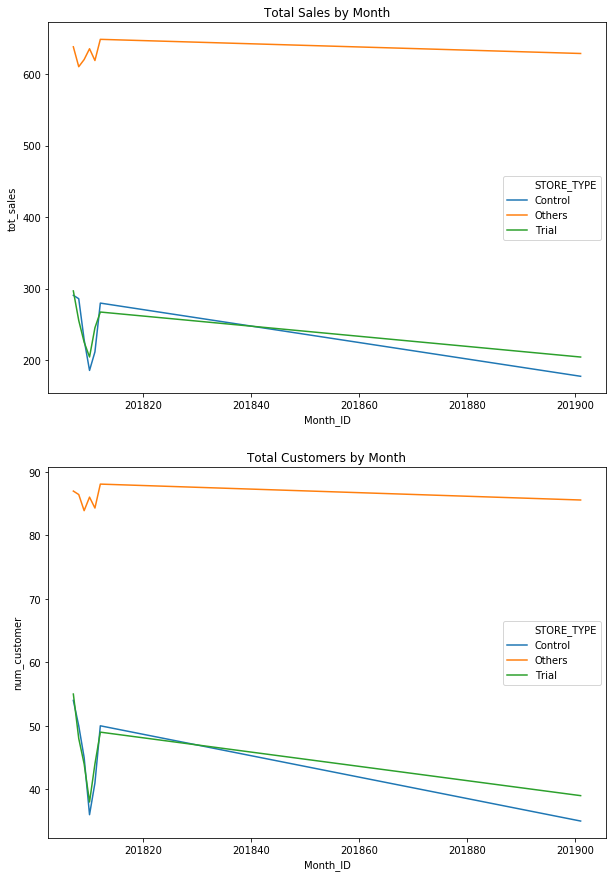

In [31]:
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
sns.lineplot(x=pastSales["Month_ID"], y=pastSales["tot_sales"], hue=pastSales["STORE_TYPE"], ax=ax1).set_title("Total Sales by Month")
sns.lineplot(x=pastCust["Month_ID"], y=pastCust["num_customer"], hue=pastCust["STORE_TYPE"], ax=ax2).set_title("Total Customers by Month")

In [32]:
data_metrics_pre["Month_ID"] = data_metrics_pre["Month_ID"].astype(str).str.replace("-", "").astype(float)
trial_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == trial_store) & (data_metrics_pre["Month_ID"] < 201902)]["tot_sales"]
control_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == control_store) & (data_metrics_pre["Month_ID"] < 201902)]["tot_sales"]

scalingFactorForControlSales = trial_metrics.sum()/control_metrics.sum()
scalingFactorForControlSales

1.023617303289553

In [53]:
data_metrics_sales = data_metrics_fs.copy()
scaled_control_sales = data_metrics_sales[data_metrics_sales["STORE_NBR"] == control_store]
scaled_control_sales["controlSales"] = data_metrics_sales["tot_sales"]*scalingFactorForControlSales
scaled_control_sales = scaled_control_sales.drop(["num_customer", "tot_sales", "avg_transaction","avg_chips","avg_price_per_quantity"], axis=1).reindex()
scaled_control_sales

,STORE_NBR,Month_ID,controlSales
2699,233,2018-07,297.565550
2700,233,2018-08,292.652187
2701,233,2018-09,233.998916
2702,233,2018-10,190.085733
2703,233,2018-11,216.597421
2704,233,2018-12,286.408121
2705,233,2019-01,181.692071
2706,233,2019-02,249.762622
2707,233,2019-03,203.802205
2708,233,2019-04,162.345704


Now that we have comparable sales figures, we can find the percentage difference between the scaled control store and trial store's during the trial period.

In [156]:
trial_df_totsales = data_metrics_fs[data_metrics_fs["STORE_NBR"] == trial_store].drop(["avg_transaction", "avg_chips", "avg_price_per_quantity", "num_customer"], axis=1)
trial_df_totsales

,STORE_NBR,Month_ID,tot_sales
880,77,2018-07,296.8
881,77,2018-08,255.5
882,77,2018-09,225.2
883,77,2018-10,204.5
884,77,2018-11,245.3
885,77,2018-12,267.3
886,77,2019-01,204.4
887,77,2019-02,235.0
888,77,2019-03,278.5
889,77,2019-04,263.5


In [158]:
percent_dif = trial_df_totsales.merge(scaled_control_sales, on=("Month_ID")).rename({"STORE_NBR_x": "TRIAL", "STORE_NBR_y": "CONTROL"}, axis=1)
percent_dif = percent_dif[["TRIAL", "CONTROL", "Month_ID", "tot_sales", "controlSales"]]
percent_dif["percentage_difference"] = np.abs((percent_dif["tot_sales"] - percent_dif["controlSales"])/((percent_dif["tot_sales"] + percent_dif["controlSales"])/2))
percent_dif

,TRIAL,CONTROL,Month_ID,tot_sales,controlSales,percentage_difference
0,77,233,2018-07,296.8,297.565550,0.002576
1,77,233,2018-08,255.5,292.652187,0.135554
2,77,233,2018-09,225.2,233.998916,0.038323
3,77,233,2018-10,204.5,190.085733,0.073060
4,77,233,2018-11,245.3,216.597421,0.124281
5,77,233,2018-12,267.3,286.408121,0.069019
6,77,233,2019-01,204.4,181.692071,0.117630
7,77,233,2019-02,235.0,249.762622,0.060907
8,77,233,2019-03,278.5,203.802205,0.309755
9,77,233,2019-04,263.5,162.345704,0.475075


We need to see if the difference is significant.
- H0: trial = pre-trial
- H1: trial ≠ pre-trial

In [67]:
#Take standard deviation of percentage difference
stdDev = percent_dif["percentage_difference"].std()
stdDev

0.13056002105171627

In [69]:
#There are 8 months in the pre-trial period so degrees of freedom = 8 - 1 = 7
degreesOfFreedom = 7

#We will test the null hypothesis being 0 difference between trial and control stores
percent_dif["tvalue"] = np.abs(percent_dif["percentage_difference"] - percent_dif["percentage_difference"].mean())/stdDev
percent_dif

,TRIAL,CONTROL,Month_ID,tot_sales,controlSales,percentage_difference,tvalue
0,77,233,2018-07,296.8,297.565550,0.002576,1.082115
1,77,233,2018-08,255.5,292.652187,0.135554,0.063593
2,77,233,2018-09,225.2,233.998916,0.038323,0.808319
3,77,233,2018-10,204.5,190.085733,0.073060,0.542255
4,77,233,2018-11,245.3,216.597421,0.124281,0.149938
5,77,233,2018-12,267.3,286.408121,0.069019,0.573210
6,77,233,2019-01,204.4,181.692071,0.117630,0.200884
7,77,233,2019-02,235.0,249.762622,0.060907,0.635343
8,77,233,2019-03,278.5,203.802205,0.309755,1.270665
9,77,233,2019-04,263.5,162.345704,0.475075,2.536901


In [71]:
#Let's filter for the trial period
percent_trial = percent_dif[percent_dif["Month_ID"] > "2019-01"]
percent_trial

,TRIAL,CONTROL,Month_ID,tot_sales,controlSales,percentage_difference,tvalue
7,77,233,2019-02,235.0,249.762622,0.060907,0.635343
8,77,233,2019-03,278.5,203.802205,0.309755,1.270665
9,77,233,2019-04,263.5,162.345704,0.475075,2.536901
10,77,233,2019-05,299.3,352.533799,0.163335,0.149192
11,77,233,2019-06,264.7,226.219424,0.156769,0.098900


We can observe that the tvalue is much larger than 95th percentile value of the t-distribution for March and April. This means that the increase in sales in the trial store in March and April is significantly greater than in the control store. Let's get a better look by plotting the sales of the control store, sales of the trial store, and the 95th percentile value of sales of the control store.

Text(0.5, 1.0, 'Total Sales by Month')

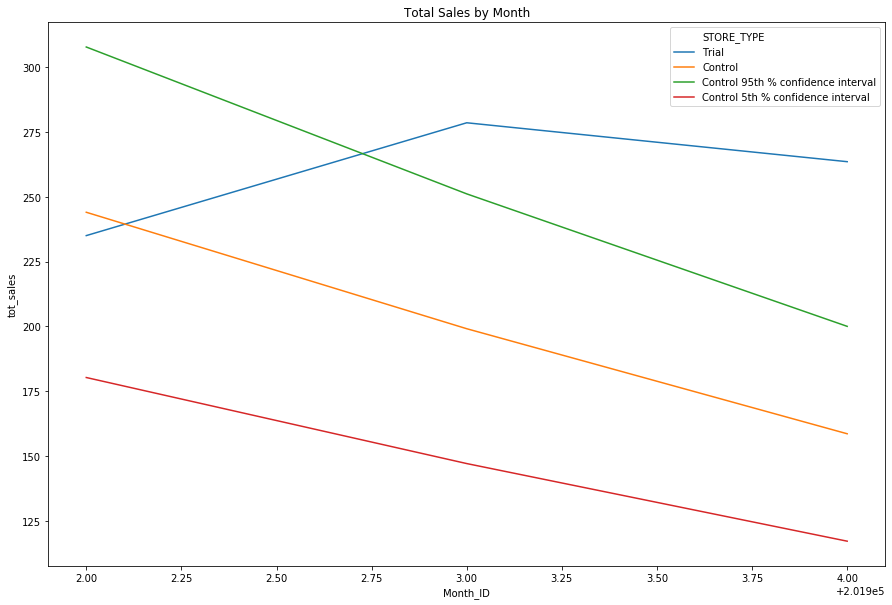

In [150]:
measure_over_time_sales = data_metrics_fs[["STORE_NBR", "Month_ID", "tot_sales"]]
measure_over_time_sales["Month_ID"] = measure_over_time_sales["Month_ID"].astype(str).str.replace("-", "").astype(int)
measure_over_time_sales["STORE_NBR"] = measure_over_time_sales["STORE_NBR"].apply(updateStores)
measure_over_time_sales = measure_over_time_sales.rename({"STORE_NBR": "STORE_TYPE"}, axis=1)
measure_over_time_sales = measure_over_time_sales[measure_over_time_sales["STORE_TYPE"].isin(["Control", "Trial"])]

#Control Store 95th Percentile
pastSales_control95 = measure_over_time_sales[measure_over_time_sales["STORE_TYPE"] == "Control"]
pastSales_control95["tot_sales"] = pastSales_control95["tot_sales"] * (1 + stdDev * 2)
pastSales_control95["STORE_TYPE"] = "Control 95th % confidence interval"
pastSales_control95

#Control Store 95th Percentile
pastSales_control5 = measure_over_time_sales[measure_over_time_sales["STORE_TYPE"] == "Control"]
pastSales_control5["tot_sales"] = pastSales_control5["tot_sales"] * (1 - stdDev * 2)
pastSales_control5["STORE_TYPE"] = "Control 5th % confidence interval"
pastSales_control5

trialAssesment = pd.concat([measure_over_time_sales, pastSales_control95, pastSales_control5])
trialAssesment
trialAssesment_month = trialAssesment[(trialAssesment["Month_ID"] > 201901) & (trialAssesment["Month_ID"] < 201905)]
month_label = trialAssesment_month["Month_ID"].astype(str).unique()

#Plot into a graph
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1)
sns.lineplot(x="Month_ID", y="tot_sales", hue="STORE_TYPE", data=trialAssesment_month, ax=ax1).set_title("Total Sales by Month")

The results show that the trial in store 77 is significantly different to its control store in the trial period since the trial store performance lies outside of the 5% and 95% confidence interval of the control store in two out of three trial months.

Let's asses this for the number of customers as well.

In [151]:
data_metrics_pre["Month_ID"] = data_metrics_pre["Month_ID"].astype(str).str.replace("-", "").astype(float)
trial_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == trial_store) & (data_metrics_pre["Month_ID"] < 201902)]["num_customer"]
control_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == control_store) & (data_metrics_pre["Month_ID"] < 201902)]["num_customer"]

scalingFactorForControlCust = trial_metrics.sum()/control_metrics.sum()
scalingFactorForControlCust

1.0192926045016077

In [153]:
data_metrics_cust = data_metrics_fs.copy()
scaled_control_cust = data_metrics_cust[data_metrics_cust["STORE_NBR"] == control_store]
scaled_control_cust["controlCust"] = data_metrics_cust["tot_sales"]*scalingFactorForControlCust
scaled_control_cust = scaled_control_cust.drop(["num_customer", "tot_sales", "avg_transaction","avg_chips","avg_price_per_quantity"], axis=1).reindex()
scaled_control_cust

,STORE_NBR,Month_ID,controlCust
2699,233,2018-07,296.308360
2700,233,2018-08,291.415756
2701,233,2018-09,233.010289
2702,233,2018-10,189.282637
2703,233,2018-11,215.682315
2704,233,2018-12,285.198071
2705,233,2019-01,180.924437
2706,233,2019-02,248.707395
2707,233,2019-03,202.941158
2708,233,2019-04,161.659807


In [159]:
trial_df_cust = data_metrics_fs[data_metrics_fs["STORE_NBR"] == trial_store].drop(["avg_transaction", "avg_chips", "avg_price_per_quantity", "tot_sales"], axis=1)
trial_df_cust

,STORE_NBR,Month_ID,num_customer
880,77,2018-07,55
881,77,2018-08,48
882,77,2018-09,44
883,77,2018-10,38
884,77,2018-11,44
885,77,2018-12,49
886,77,2019-01,39
887,77,2019-02,45
888,77,2019-03,55
889,77,2019-04,48


In [163]:
percent_dif_cust = trial_df_cust.merge(scaled_control_cust, on=("Month_ID")).rename({"STORE_NBR_x": "TRIAL", "STORE_NBR_y": "CONTROL"}, axis=1)
percent_dif_cust = percent_dif_cust[["TRIAL", "CONTROL", "Month_ID", "num_customer", "controlCust"]]
percent_dif_cust["percentage_difference"] = np.abs((percent_dif_cust["num_customer"] - percent_dif_cust["controlCust"])/((percent_dif_cust["num_customer"] + percent_dif_cust["controlCust"])/2))
percent_dif_cust

,TRIAL,CONTROL,Month_ID,num_customer,controlCust,percentage_difference
0,77,233,2018-07,55,296.308360,1.373770
1,77,233,2018-08,48,291.415756,1.434322
2,77,233,2018-09,44,233.010289,1.364645
3,77,233,2018-10,38,189.282637,1.331229
4,77,233,2018-11,44,215.682315,1.322249
5,77,233,2018-12,49,285.198071,1.413521
6,77,233,2019-01,39,180.924437,1.290665
7,77,233,2019-02,45,248.707395,1.387145
8,77,233,2019-03,55,202.941158,1.147092
9,77,233,2019-04,48,161.659807,1.084231


In [164]:
#Take standard deviation of percentage difference
stdDev_cust = percent_dif_cust["percentage_difference"].std()

#There are 8 months in the pre-trial period so degrees of freedom = 8 - 1 = 7
degreesOfFreedom = 7

#We will test the null hypothesis being 0 difference between trial and control stores
percent_dif_cust["tvalue"] = np.abs(percent_dif_cust["percentage_difference"] - percent_dif_cust["percentage_difference"].mean())/stdDev
percent_dif_cust

,TRIAL,CONTROL,Month_ID,num_customer,controlCust,percentage_difference,tvalue
0,77,233,2018-07,55,296.308360,1.373770,0.328882
1,77,233,2018-08,48,291.415756,1.434322,0.792673
2,77,233,2018-09,44,233.010289,1.364645,0.258991
3,77,233,2018-10,38,189.282637,1.331229,0.003052
4,77,233,2018-11,44,215.682315,1.322249,0.065731
5,77,233,2018-12,49,285.198071,1.413521,0.633355
6,77,233,2019-01,39,180.924437,1.290665,0.307638
7,77,233,2019-02,45,248.707395,1.387145,0.431330
8,77,233,2019-03,55,202.941158,1.147092,1.407310
9,77,233,2019-04,48,161.659807,1.084231,1.888786


In [165]:
#Let's filter for the trial period
percent_trial = percent_dif_cust[percent_dif_cust["Month_ID"] > "2019-01"]
percent_trial

,TRIAL,CONTROL,Month_ID,num_customer,controlCust,percentage_difference,tvalue
7,77,233,2019-02,45,248.707395,1.387145,0.431330
8,77,233,2019-03,55,202.941158,1.147092,1.407310
9,77,233,2019-04,48,161.659807,1.084231,1.888786
10,77,233,2019-05,56,351.044373,1.449691,0.910392
11,77,233,2019-06,42,225.263666,1.371407,0.310789


Text(0.5, 1.0, 'Total Customer by Month')

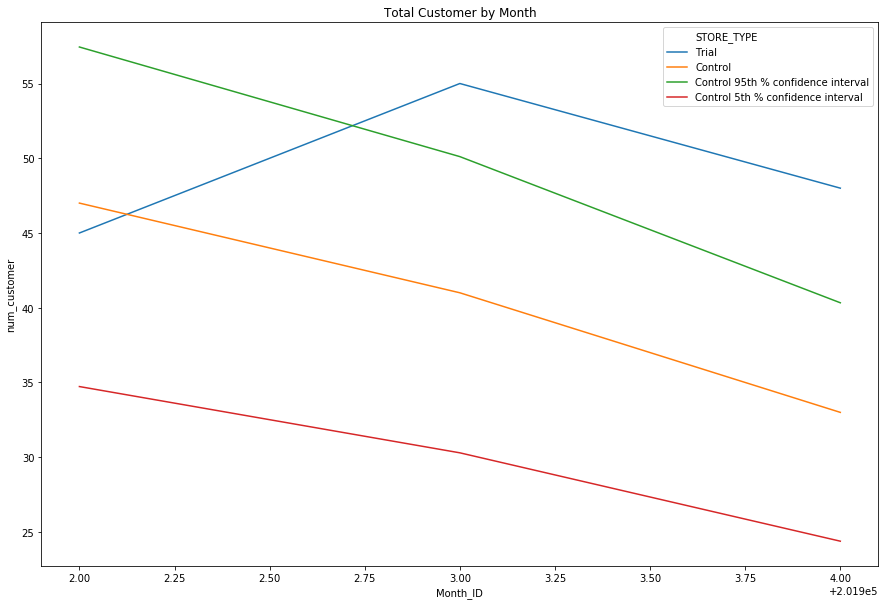

In [167]:
measure_over_time_cust = data_metrics_fs[["STORE_NBR", "Month_ID", "num_customer"]]
measure_over_time_cust["Month_ID"] = measure_over_time_cust["Month_ID"].astype(str).str.replace("-", "").astype(int)
measure_over_time_cust["STORE_NBR"] = measure_over_time_cust["STORE_NBR"].apply(updateStores)
measure_over_time_cust = measure_over_time_cust.rename({"STORE_NBR": "STORE_TYPE"}, axis=1)
measure_over_time_cust = measure_over_time_cust[measure_over_time_cust["STORE_TYPE"].isin(["Control", "Trial"])]

#Control Store 95th Percentile
pastCust_control95 = measure_over_time_cust[measure_over_time_cust["STORE_TYPE"] == "Control"]
pastCust_control95["num_customer"] = pastCust_control95["num_customer"] * (1 + stdDev_cust * 2)
pastCust_control95["STORE_TYPE"] = "Control 95th % confidence interval"
pastCust_control95

#Control Store 95th Percentile
pastCust_control5 = measure_over_time_cust[measure_over_time_cust["STORE_TYPE"] == "Control"]
pastCust_control5["num_customer"] = pastCust_control5["num_customer"] * (1 - stdDev * 2)
pastCust_control5["STORE_TYPE"] = "Control 5th % confidence interval"
pastCust_control5

trialAssesment = pd.concat([measure_over_time_cust, pastCust_control95, pastCust_control5])
trialAssesment
trialAssesment_month = trialAssesment[(trialAssesment["Month_ID"] > 201901) & (trialAssesment["Month_ID"] < 201905)]
month_label = trialAssesment_month["Month_ID"].astype(str).unique()

#Plot into a graph
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1)
sns.lineplot(x="Month_ID", y="num_customer", hue="STORE_TYPE", data=trialAssesment_month, ax=ax1).set_title("Total Customer by Month")

Let's find the control stores for the other two trial stores.

## Trial Store 86

In [196]:
trial_store = 86
corr_nSales = CalculateCorrelation(data_metrics_pre, "tot_sales", trial_store)
magnitude_nSales = CalculateMagnitudeDistance(data_metrics_pre, "tot_sales", trial_store)
corr_nCustomer = CalculateCorrelation(data_metrics_pre, "num_customer", trial_store)
magnitude_nCustomer = CalculateMagnitudeDistance(data_metrics_pre, "num_customer", trial_store)
magnitude_nCustomer

,STORE1,STORE2,num_customer
0,86,1,0.368820
1,86,2,0.317181
2,86,3,0.895408
3,86,4,0.810598
4,86,5,0.918582
...,...,...,...
255,86,268,0.356740
256,86,269,0.901480
257,86,270,0.837718
258,86,271,0.919883


In [197]:
score_nSales = corr_nSales.merge(magnitude_nSales, on=["STORE1", "STORE2"])
score_nSales = score_nSales.rename({"tot_sales": "MAGNITUDESALES"}, axis=1)
score_nSales["scoreNSales"] = np.abs(0.5*score_nSales["COORMEASURE"] + 0.5*score_nSales["MAGNITUDESALES"])

score_nCust = corr_nCustomer.merge(magnitude_nCustomer, on=["STORE1", "STORE2"])
score_nCust = score_nCust.rename({"num_customer": "MAGNITUDECUST"}, axis=1)
score_nCust["scoreNCust"] = np.abs(0.5*score_nCust["COORMEASURE"] + 0.5*score_nCust["MAGNITUDECUST"])

score_control = score_nCust.merge(score_nSales, on=["STORE1", "STORE2"])
score_control = score_control.drop(["COORMEASURE_x", "MAGNITUDECUST", "COORMEASURE_y", "MAGNITUDESALES"], axis=1)
score_control["finalControlScore"] = np.abs(score_control["scoreNSales"] * 0.5 + score_control["scoreNCust"] * 0.5)
score_control.sort_values(by="finalControlScore", ascending=False)

,STORE1,STORE2,scoreNCust,scoreNSales,finalControlScore
80,86,86,1.000000,1.000000,1.000000
130,86,138,0.899832,0.841792,0.870812
147,86,155,0.808900,0.920423,0.864662
210,86,222,0.746548,0.877096,0.811822
139,86,147,0.860589,0.727811,0.794200
...,...,...,...,...,...
128,86,136,0.037854,0.047265,0.042560
150,86,158,0.066134,0.018647,0.042390
21,86,23,0.039235,0.035547,0.037391
46,86,50,0.033323,0.032130,0.032726


Looks like store 138 is the control store for store 86. Again, we will visualize this into a graph.

In [200]:
trial_store = 86
control_store = 138

measure_over_time = data_metrics_pre.copy()
measure_over_time["STORE_TYPE"] = measure_over_time["STORE_NBR"].apply(updateStores)
measure_over_time["STORE_TYPE"].unique()

pastSales = measure_over_time.groupby(["STORE_TYPE", "Month_ID"]).agg("mean")["tot_sales"].reset_index()
pastSales["Month_ID"] = pastSales["Month_ID"].astype(str).str.replace("-", "").astype(float)

pastCust = measure_over_time.groupby(["STORE_TYPE", "Month_ID"]).agg("mean")["num_customer"].reset_index()
pastCust["Month_ID"] = pastCust["Month_ID"].astype(str).str.replace("-", "").astype(float)
pastCust

,STORE_TYPE,Month_ID,num_customer
0,Control,201807.0,54.000000
1,Control,201808.0,50.000000
2,Control,201809.0,45.000000
3,Control,201810.0,36.000000
4,Control,201811.0,41.000000
5,Control,201812.0,50.000000
6,Control,201901.0,35.000000
7,Others,201807.0,86.965116
8,Others,201808.0,86.418605
9,Others,201809.0,83.879845


Text(0.5, 1.0, 'Total Customers by Month')

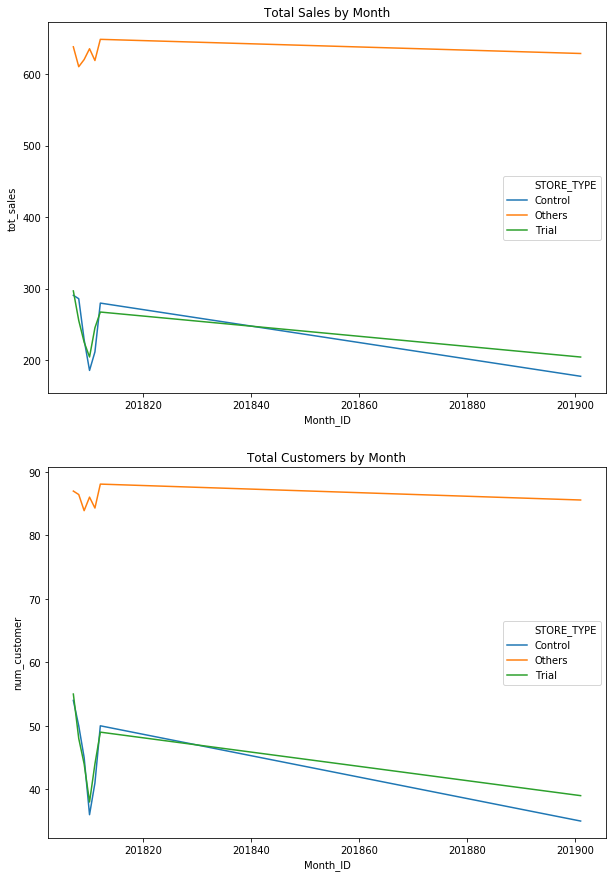

In [183]:
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
sns.lineplot(x=pastSales["Month_ID"], y=pastSales["tot_sales"], hue=pastSales["STORE_TYPE"], ax=ax1).set_title("Total Sales by Month")
sns.lineplot(x=pastCust["Month_ID"], y=pastCust["num_customer"], hue=pastCust["STORE_TYPE"], ax=ax2).set_title("Total Customers by Month")

Great, the trends for both Total sales and Total Customers are very similar. Next, less asses the impact of the trial on sales.

In [189]:
data_metrics_pre["Month_ID"] = data_metrics_pre["Month_ID"].astype(str).str.replace("-", "").astype(float)
trial_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == trial_store) & (data_metrics_pre["Month_ID"] < 201902)]["tot_sales"]
control_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == control_store) & (data_metrics_pre["Month_ID"] < 201902)]["tot_sales"]

scalingFactorForControlSales = trial_metrics.sum()/control_metrics.sum()

data_metrics_sales = data_metrics_fs.copy()
scaled_control_sales = data_metrics_sales[data_metrics_sales["STORE_NBR"] == control_store]
scaled_control_sales["controlSales"] = data_metrics_sales["tot_sales"]*scalingFactorForControlSales
scaled_control_sales = scaled_control_sales.drop(["num_customer", "tot_sales", "avg_transaction","avg_chips","avg_price_per_quantity"], axis=1).reindex()

trial_df_totsales = data_metrics_fs[data_metrics_fs["STORE_NBR"] == trial_store].drop(["avg_transaction", "avg_chips", "avg_price_per_quantity", "num_customer"], axis=1)

percent_dif = trial_df_totsales.merge(scaled_control_sales, on=("Month_ID")).rename({"STORE_NBR_x": "TRIAL", "STORE_NBR_y": "CONTROL"}, axis=1)
percent_dif = percent_dif[["TRIAL", "CONTROL", "Month_ID", "tot_sales", "controlSales"]]
percent_dif["percentage_difference"] = np.abs((percent_dif["tot_sales"] - percent_dif["controlSales"])/((percent_dif["tot_sales"] + percent_dif["controlSales"])/2))
percent_dif

#Take standard deviation of percent difference
stdDev = percent_dif["percentage_difference"].std()

#There are 8 months in the pre-trial period so degrees of freedom = 8 - 1 = 7
degreesOfFreedom = 7

#We will test the null hypothesis being 0 difference between trial and control stores
percent_dif["tvalue"] = np.abs(percent_dif["percentage_difference"] - percent_dif["percentage_difference"].mean())/stdDev

#Let's filter for the trial period
percent_trial = percent_dif[percent_dif["Month_ID"] > "2019-01"]
percent_trial

,TRIAL,CONTROL,Month_ID,tot_sales,controlSales,percentage_difference,tvalue
7,86,138,2019-02,913.2,724.548428,0.230379,1.621266
8,86,138,2019-03,1026.8,910.379711,0.120196,0.193940
9,86,138,2019-04,848.2,807.398208,0.049289,0.724584
10,86,138,2019-05,889.3,805.656040,0.098697,0.084548
11,86,138,2019-06,838.0,1109.180468,0.278537,2.245101


Text(0.5, 1.0, 'Total Sales by Month')

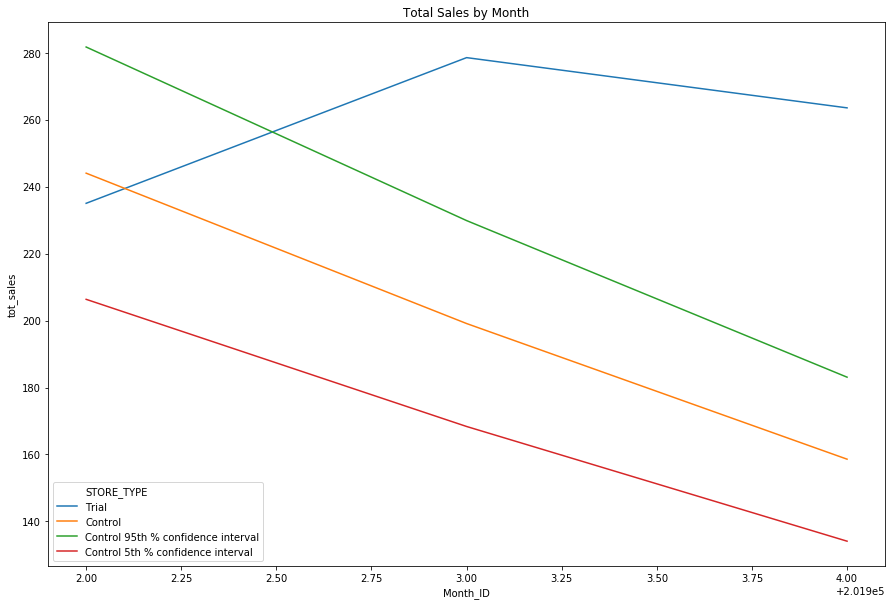

In [190]:
measure_over_time_sales = data_metrics_fs[["STORE_NBR", "Month_ID", "tot_sales"]]
measure_over_time_sales["Month_ID"] = measure_over_time_sales["Month_ID"].astype(str).str.replace("-", "").astype(int)
measure_over_time_sales["STORE_NBR"] = measure_over_time_sales["STORE_NBR"].apply(updateStores)
measure_over_time_sales = measure_over_time_sales.rename({"STORE_NBR": "STORE_TYPE"}, axis=1)
measure_over_time_sales = measure_over_time_sales[measure_over_time_sales["STORE_TYPE"].isin(["Control", "Trial"])]

#Control Store 95th Percentile
pastSales_control95 = measure_over_time_sales[measure_over_time_sales["STORE_TYPE"] == "Control"]
pastSales_control95["tot_sales"] = pastSales_control95["tot_sales"] * (1 + stdDev * 2)
pastSales_control95["STORE_TYPE"] = "Control 95th % confidence interval"
pastSales_control95

#Control Store 95th Percentile
pastSales_control5 = measure_over_time_sales[measure_over_time_sales["STORE_TYPE"] == "Control"]
pastSales_control5["tot_sales"] = pastSales_control5["tot_sales"] * (1 - stdDev * 2)
pastSales_control5["STORE_TYPE"] = "Control 5th % confidence interval"
pastSales_control5

trialAssesment = pd.concat([measure_over_time_sales, pastSales_control95, pastSales_control5])
trialAssesment
trialAssesment_month = trialAssesment[(trialAssesment["Month_ID"] > 201901) & (trialAssesment["Month_ID"] < 201905)]
month_label = trialAssesment_month["Month_ID"].astype(str).unique()

#Plot into a graph
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1)
sns.lineplot(x="Month_ID", y="tot_sales", hue="STORE_TYPE", data=trialAssesment_month, ax=ax1).set_title("Total Sales by Month")

It looks like the sales of trial store 86 are not very different from its control store; 2 of the 3 months are out of the 5th to 95th percentile. Let's take a look at the total customer now.

In [191]:
data_metrics_pre["Month_ID"] = data_metrics_pre["Month_ID"].astype(str).str.replace("-", "").astype(float)
trial_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == trial_store) & (data_metrics_pre["Month_ID"] < 201902)]["num_customer"]
control_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == control_store) & (data_metrics_pre["Month_ID"] < 201902)]["num_customer"]

scalingFactorForControlCust = trial_metrics.sum()/control_metrics.sum()

data_metrics_cust = data_metrics_fs.copy()
scaled_control_cust = data_metrics_cust[data_metrics_cust["STORE_NBR"] == control_store]
scaled_control_cust["controlCust"] = data_metrics_cust["tot_sales"]*scalingFactorForControlCust
scaled_control_cust = scaled_control_cust.drop(["num_customer", "tot_sales", "avg_transaction","avg_chips","avg_price_per_quantity"], axis=1).reindex()

trial_df_cust = data_metrics_fs[data_metrics_fs["STORE_NBR"] == trial_store].drop(["avg_transaction", "avg_chips", "avg_price_per_quantity", "tot_sales"], axis=1)

percent_dif_cust = trial_df_cust.merge(scaled_control_cust, on=("Month_ID")).rename({"STORE_NBR_x": "TRIAL", "STORE_NBR_y": "CONTROL"}, axis=1)
percent_dif_cust = percent_dif_cust[["TRIAL", "CONTROL", "Month_ID", "num_customer", "controlCust"]]
percent_dif_cust["percentage_difference"] = np.abs((percent_dif_cust["num_customer"] - percent_dif_cust["controlCust"])/((percent_dif_cust["num_customer"] + percent_dif_cust["controlCust"])/2))
percent_dif_cust

,TRIAL,CONTROL,Month_ID,num_customer,controlCust,percentage_difference
0,86,138,2018-07,126,792.739672,1.451422
1,86,138,2018-08,112,681.887213,1.435688
2,86,138,2018-09,129,880.650492,1.488932
3,86,138,2018-10,138,978.779016,1.505721
4,86,138,2018-11,127,955.644590,1.530779
5,86,138,2018-12,120,884.891803,1.522337
6,86,138,2019-01,130,920.364590,1.504934
7,86,138,2019-02,139,721.601311,1.353940
8,86,138,2019-03,142,906.676721,1.458365
9,86,138,2019-04,127,804.114098,1.454417


In [192]:
#Take standard deviation of percentage difference
stdDev_cust = percent_dif_cust["percentage_difference"].std()

#There are 8 months in the pre-trial period so degrees of freedom = 8 - 1 = 7
degreesOfFreedom = 7

#We will test the null hypothesis being 0 difference between trial and control stores
percent_dif_cust["tvalue"] = np.abs(percent_dif_cust["percentage_difference"] - percent_dif_cust["percentage_difference"].mean())/stdDev

#Let's filter for the trial period
percent_trial = percent_dif_cust[percent_dif_cust["Month_ID"] > "2019-01"]
percent_trial

,TRIAL,CONTROL,Month_ID,num_customer,controlCust,percentage_difference,tvalue
7,86,138,2019-02,139,721.601311,1.353940,1.636794
8,86,138,2019-03,142,906.676721,1.458365,0.284065
9,86,138,2019-04,127,804.114098,1.454417,0.335208
10,86,138,2019-05,129,802.379016,1.445983,0.444465
11,86,138,2019-06,119,1104.668852,1.611006,1.693256


Text(0.5, 1.0, 'Total Customer by Month')

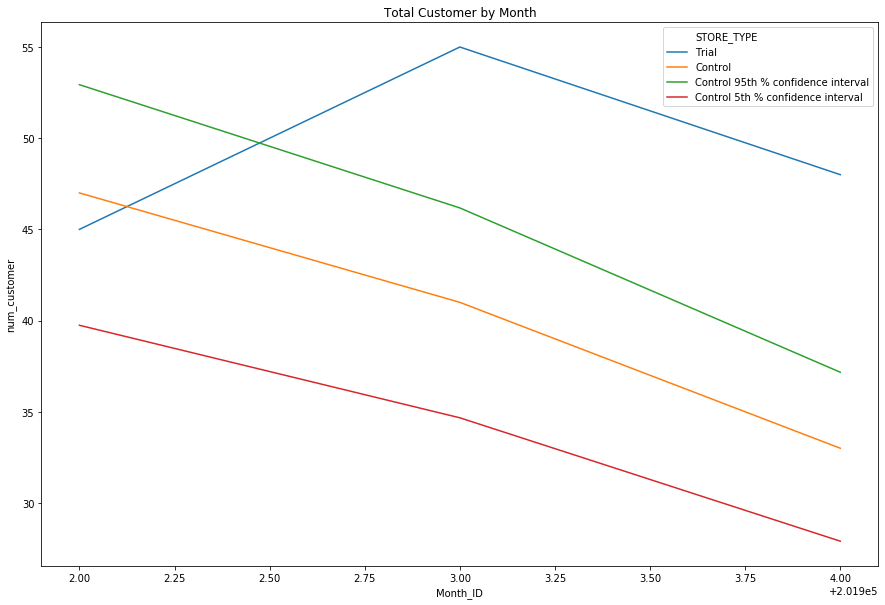

In [193]:
measure_over_time_cust = data_metrics_fs[["STORE_NBR", "Month_ID", "num_customer"]]
measure_over_time_cust["Month_ID"] = measure_over_time_cust["Month_ID"].astype(str).str.replace("-", "").astype(int)
measure_over_time_cust["STORE_NBR"] = measure_over_time_cust["STORE_NBR"].apply(updateStores)
measure_over_time_cust = measure_over_time_cust.rename({"STORE_NBR": "STORE_TYPE"}, axis=1)
measure_over_time_cust = measure_over_time_cust[measure_over_time_cust["STORE_TYPE"].isin(["Control", "Trial"])]

#Control Store 95th Percentile
pastCust_control95 = measure_over_time_cust[measure_over_time_cust["STORE_TYPE"] == "Control"]
pastCust_control95["num_customer"] = pastCust_control95["num_customer"] * (1 + stdDev_cust * 2)
pastCust_control95["STORE_TYPE"] = "Control 95th % confidence interval"
pastCust_control95

#Control Store 95th Percentile
pastCust_control5 = measure_over_time_cust[measure_over_time_cust["STORE_TYPE"] == "Control"]
pastCust_control5["num_customer"] = pastCust_control5["num_customer"] * (1 - stdDev * 2)
pastCust_control5["STORE_TYPE"] = "Control 5th % confidence interval"
pastCust_control5

trialAssesment = pd.concat([measure_over_time_cust, pastCust_control95, pastCust_control5])
trialAssesment
trialAssesment_month = trialAssesment[(trialAssesment["Month_ID"] > 201901) & (trialAssesment["Month_ID"] < 201905)]
month_label = trialAssesment_month["Month_ID"].astype(str).unique()

#Plot into a graph
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1)
sns.lineplot(x="Month_ID", y="num_customer", hue="STORE_TYPE", data=trialAssesment_month, ax=ax1).set_title("Total Customer by Month")

It seems like the number of customers is significantly higher in 2 out of the 3 months. It suggest that there is a significant impact on increasing the number of customers in trial store 86. The increase in number of customers is way higher than the increase in sales. However, as we saw, the sales were not significantly higher. This might be due to special deals in trial store which might result in lower prices, impacting the results. Let's perform the same assesments for trial store 88

## Trial Store 88

In [198]:
trial_store = 88
corr_nSales = CalculateCorrelation(data_metrics_pre, "tot_sales", trial_store)
magnitude_nSales = CalculateMagnitudeDistance(data_metrics_pre, "tot_sales", trial_store)
corr_nCustomer = CalculateCorrelation(data_metrics_pre, "num_customer", trial_store)
magnitude_nCustomer = CalculateMagnitudeDistance(data_metrics_pre, "num_customer", trial_store)

score_nSales = corr_nSales.merge(magnitude_nSales, on=["STORE1", "STORE2"])
score_nSales = score_nSales.rename({"tot_sales": "MAGNITUDESALES"}, axis=1)
score_nSales["scoreNSales"] = (0.5*score_nSales["COORMEASURE"] + 0.5*score_nSales["MAGNITUDESALES"])

score_nCust = corr_nCustomer.merge(magnitude_nCustomer, on=["STORE1", "STORE2"])
score_nCust = score_nCust.rename({"num_customer": "MAGNITUDECUST"}, axis=1)
score_nCust["scoreNCust"] = (0.5*score_nCust["COORMEASURE"] + 0.5*score_nCust["MAGNITUDECUST"])

score_control = score_nCust.merge(score_nSales, on=["STORE1", "STORE2"])
score_control = score_control.drop(["COORMEASURE_x", "MAGNITUDECUST", "COORMEASURE_y", "MAGNITUDESALES"], axis=1)
score_control["finalControlScore"] = np.abs(score_control["scoreNSales"] * 0.5 + score_control["scoreNCust"] * 0.5)
score_control.sort_values(by="finalControlScore", ascending=False)

,STORE1,STORE2,scoreNCust,scoreNSales,finalControlScore
82,88,88,1.000000,1.000000,1.000000
6,88,7,0.865827,0.713819,0.789823
115,88,123,0.889912,0.627976,0.758944
170,88,178,0.767809,0.713855,0.740832
194,88,203,0.729727,0.729388,0.729558
...,...,...,...,...,...
231,88,243,-0.106289,0.095223,0.005533
79,88,84,0.019109,-0.008622,0.005244
70,88,74,0.013400,-0.018047,0.002324
69,88,73,0.037965,-0.034092,0.001936


Store 7 will be our control store for trial 88.

In [201]:
trial_store = 88
control_store = 7

measure_over_time = data_metrics_pre.copy()
measure_over_time["STORE_TYPE"] = measure_over_time["STORE_NBR"].apply(updateStores)
measure_over_time["STORE_TYPE"].unique()

pastSales = measure_over_time.groupby(["STORE_TYPE", "Month_ID"]).agg("mean")["tot_sales"].reset_index()
pastSales["Month_ID"] = pastSales["Month_ID"].astype(str).str.replace("-", "").astype(float)

pastCust = measure_over_time.groupby(["STORE_TYPE", "Month_ID"]).agg("mean")["num_customer"].reset_index()
pastCust["Month_ID"] = pastCust["Month_ID"].astype(str).str.replace("-", "").astype(float)
pastCust

,STORE_TYPE,Month_ID,num_customer
0,Control,201807.0,54.000000
1,Control,201808.0,50.000000
2,Control,201809.0,45.000000
3,Control,201810.0,36.000000
4,Control,201811.0,41.000000
5,Control,201812.0,50.000000
6,Control,201901.0,35.000000
7,Others,201807.0,86.965116
8,Others,201808.0,86.418605
9,Others,201809.0,83.879845


Text(0.5, 1.0, 'Total Customers by Month')

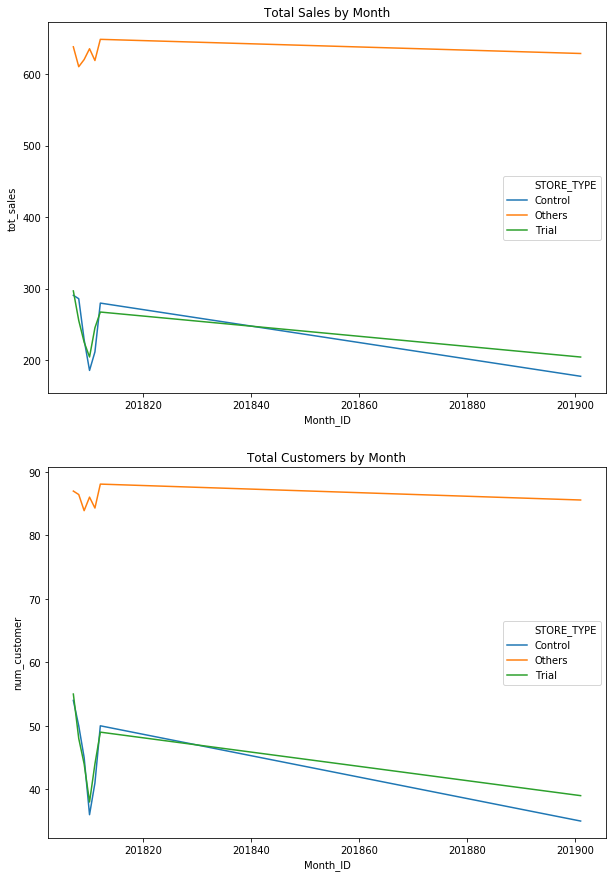

In [202]:
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
sns.lineplot(x=pastSales["Month_ID"], y=pastSales["tot_sales"], hue=pastSales["STORE_TYPE"], ax=ax1).set_title("Total Sales by Month")
sns.lineplot(x=pastCust["Month_ID"], y=pastCust["num_customer"], hue=pastCust["STORE_TYPE"], ax=ax2).set_title("Total Customers by Month")

The trends between total sales and total customers are very similar which means that store 7 is a suiable control store. Let's asses the impact of the trial on sales

In [203]:
data_metrics_pre["Month_ID"] = data_metrics_pre["Month_ID"].astype(str).str.replace("-", "").astype(float)
trial_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == trial_store) & (data_metrics_pre["Month_ID"] < 201902)]["tot_sales"]
control_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == control_store) & (data_metrics_pre["Month_ID"] < 201902)]["tot_sales"]

scalingFactorForControlSales = trial_metrics.sum()/control_metrics.sum()

data_metrics_sales = data_metrics_fs.copy()
scaled_control_sales = data_metrics_sales[data_metrics_sales["STORE_NBR"] == control_store]
scaled_control_sales["controlSales"] = data_metrics_sales["tot_sales"]*scalingFactorForControlSales
scaled_control_sales = scaled_control_sales.drop(["num_customer", "tot_sales", "avg_transaction","avg_chips","avg_price_per_quantity"], axis=1).reindex()

trial_df_totsales = data_metrics_fs[data_metrics_fs["STORE_NBR"] == trial_store].drop(["avg_transaction", "avg_chips", "avg_price_per_quantity", "num_customer"], axis=1)

percent_dif = trial_df_totsales.merge(scaled_control_sales, on=("Month_ID")).rename({"STORE_NBR_x": "TRIAL", "STORE_NBR_y": "CONTROL"}, axis=1)
percent_dif = percent_dif[["TRIAL", "CONTROL", "Month_ID", "tot_sales", "controlSales"]]
percent_dif["percentage_difference"] = np.abs((percent_dif["tot_sales"] - percent_dif["controlSales"])/((percent_dif["tot_sales"] + percent_dif["controlSales"])/2))
percent_dif

#Take standard deviation of percent difference
stdDev = percent_dif["percentage_difference"].std()

#There are 8 months in the pre-trial period so degrees of freedom = 8 - 1 = 7
degreesOfFreedom = 7

#We will test the null hypothesis being 0 difference between trial and control stores
percent_dif["tvalue"] = np.abs(percent_dif["percentage_difference"] - percent_dif["percentage_difference"].mean())/stdDev

#Let's filter for the trial period
percent_trial = percent_dif[percent_dif["Month_ID"] > "2019-01"]
percent_trial

,TRIAL,CONTROL,Month_ID,tot_sales,controlSales,percentage_difference,tvalue
7,88,7,2019-02,1370.20,1316.924460,0.039652,0.147949
8,88,7,2019-03,1477.20,1470.120856,0.004804,0.782273
9,88,7,2019-04,1439.40,1209.148101,0.173870,2.295118
10,88,7,2019-05,1308.25,1243.533892,0.050722,0.053547
11,88,7,2019-06,1354.60,1398.013340,0.031543,0.295552


Text(0.5, 1.0, 'Total Sales by Month')

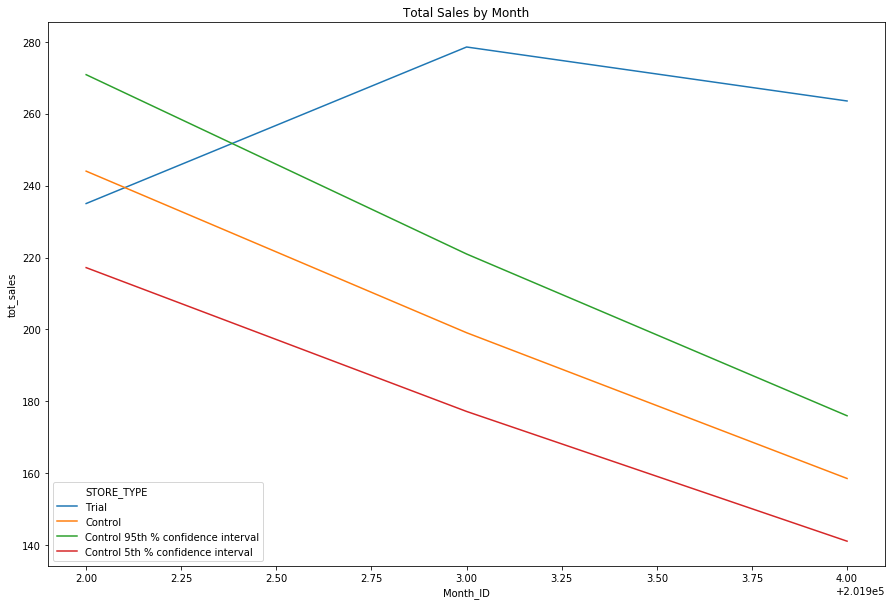

In [204]:
measure_over_time_sales = data_metrics_fs[["STORE_NBR", "Month_ID", "tot_sales"]]
measure_over_time_sales["Month_ID"] = measure_over_time_sales["Month_ID"].astype(str).str.replace("-", "").astype(int)
measure_over_time_sales["STORE_NBR"] = measure_over_time_sales["STORE_NBR"].apply(updateStores)
measure_over_time_sales = measure_over_time_sales.rename({"STORE_NBR": "STORE_TYPE"}, axis=1)
measure_over_time_sales = measure_over_time_sales[measure_over_time_sales["STORE_TYPE"].isin(["Control", "Trial"])]

#Control Store 95th Percentile
pastSales_control95 = measure_over_time_sales[measure_over_time_sales["STORE_TYPE"] == "Control"]
pastSales_control95["tot_sales"] = pastSales_control95["tot_sales"] * (1 + stdDev * 2)
pastSales_control95["STORE_TYPE"] = "Control 95th % confidence interval"
pastSales_control95

#Control Store 95th Percentile
pastSales_control5 = measure_over_time_sales[measure_over_time_sales["STORE_TYPE"] == "Control"]
pastSales_control5["tot_sales"] = pastSales_control5["tot_sales"] * (1 - stdDev * 2)
pastSales_control5["STORE_TYPE"] = "Control 5th % confidence interval"
pastSales_control5

trialAssesment = pd.concat([measure_over_time_sales, pastSales_control95, pastSales_control5])
trialAssesment
trialAssesment_month = trialAssesment[(trialAssesment["Month_ID"] > 201901) & (trialAssesment["Month_ID"] < 201905)]
month_label = trialAssesment_month["Month_ID"].astype(str).unique()

#Plot into a graph
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1)
sns.lineplot(x="Month_ID", y="tot_sales", hue="STORE_TYPE", data=trialAssesment_month, ax=ax1).set_title("Total Sales by Month")

The results show that the trial in store 88 is significantly different to its control store in the trial period since in 2 out of 3 months, the trial store lies above the 5% and 95% line. Let's look at customer as well.

In [205]:
data_metrics_pre["Month_ID"] = data_metrics_pre["Month_ID"].astype(str).str.replace("-", "").astype(float)
trial_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == trial_store) & (data_metrics_pre["Month_ID"] < 201902)]["num_customer"]
control_metrics = data_metrics_pre[(data_metrics_pre["STORE_NBR"] == control_store) & (data_metrics_pre["Month_ID"] < 201902)]["num_customer"]

scalingFactorForControlCust = trial_metrics.sum()/control_metrics.sum()

data_metrics_cust = data_metrics_fs.copy()
scaled_control_cust = data_metrics_cust[data_metrics_cust["STORE_NBR"] == control_store]
scaled_control_cust["controlCust"] = data_metrics_cust["tot_sales"]*scalingFactorForControlCust
scaled_control_cust = scaled_control_cust.drop(["num_customer", "tot_sales", "avg_transaction","avg_chips","avg_price_per_quantity"], axis=1).reindex()

trial_df_cust = data_metrics_fs[data_metrics_fs["STORE_NBR"] == trial_store].drop(["avg_transaction", "avg_chips", "avg_price_per_quantity", "tot_sales"], axis=1)

percent_dif_cust = trial_df_cust.merge(scaled_control_cust, on=("Month_ID")).rename({"STORE_NBR_x": "TRIAL", "STORE_NBR_y": "CONTROL"}, axis=1)
percent_dif_cust = percent_dif_cust[["TRIAL", "CONTROL", "Month_ID", "num_customer", "controlCust"]]
percent_dif_cust["percentage_difference"] = np.abs((percent_dif_cust["num_customer"] - percent_dif_cust["controlCust"])/((percent_dif_cust["num_customer"] + percent_dif_cust["controlCust"])/2))
percent_dif_cust

,TRIAL,CONTROL,Month_ID,num_customer,controlCust,percentage_difference
0,88,7,2018-07,153,1287.718235,1.575212
1,88,7,2018-08,160,1407.354007,1.591669
2,88,7,2018-09,159,1441.786992,1.602695
3,88,7,2018-10,158,1336.980023,1.577252
4,88,7,2018-11,157,1352.814170,1.584055
5,88,7,2018-12,149,1138.676190,1.537151
6,88,7,2019-01,146,1225.386992,1.574154
7,88,7,2019-02,154,1289.854588,1.573364
8,88,7,2019-03,170,1439.901974,1.577614
9,88,7,2019-04,162,1184.293612,1.518679


In [206]:
#Take standard deviation of percentage difference
stdDev_cust = percent_dif_cust["percentage_difference"].std()

#There are 8 months in the pre-trial period so degrees of freedom = 8 - 1 = 7
degreesOfFreedom = 7

#We will test the null hypothesis being 0 difference between trial and control stores
percent_dif_cust["tvalue"] = np.abs(percent_dif_cust["percentage_difference"] - percent_dif_cust["percentage_difference"].mean())/stdDev

#Let's filter for the trial period
percent_trial = percent_dif_cust[percent_dif_cust["Month_ID"] > "2019-01"]
percent_trial

,TRIAL,CONTROL,Month_ID,num_customer,controlCust,percentage_difference,tvalue
7,88,7,2019-02,154,1289.854588,1.573364,0.022794
8,88,7,2019-03,170,1439.901974,1.577614,0.100149
9,88,7,2019-04,162,1184.293612,1.518679,0.972609
10,88,7,2019-05,155,1217.972590,1.548425,0.431155
11,88,7,2019-06,150,1369.276655,1.605075,0.600005


Text(0.5, 1.0, 'Total Customer by Month')

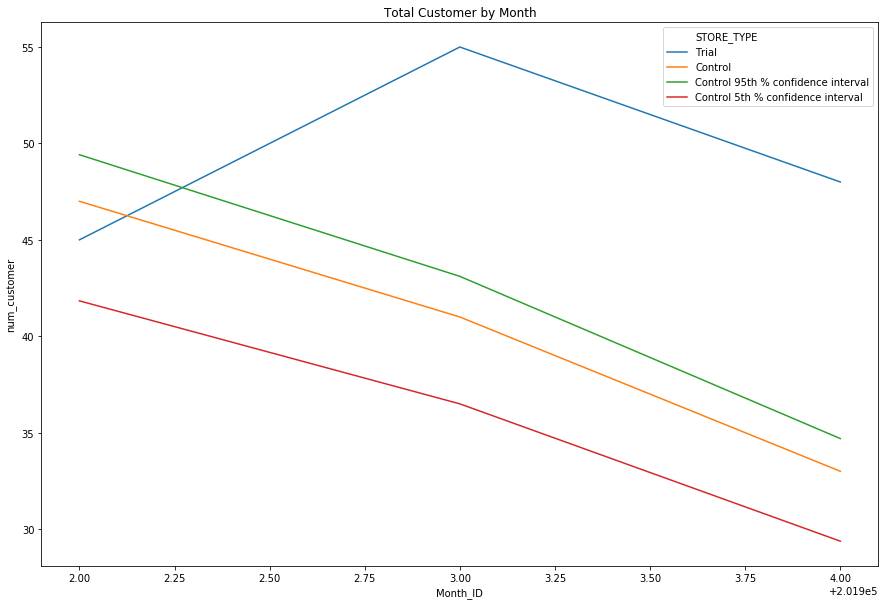

In [207]:
measure_over_time_cust = data_metrics_fs[["STORE_NBR", "Month_ID", "num_customer"]]
measure_over_time_cust["Month_ID"] = measure_over_time_cust["Month_ID"].astype(str).str.replace("-", "").astype(int)
measure_over_time_cust["STORE_NBR"] = measure_over_time_cust["STORE_NBR"].apply(updateStores)
measure_over_time_cust = measure_over_time_cust.rename({"STORE_NBR": "STORE_TYPE"}, axis=1)
measure_over_time_cust = measure_over_time_cust[measure_over_time_cust["STORE_TYPE"].isin(["Control", "Trial"])]

#Control Store 95th Percentile
pastCust_control95 = measure_over_time_cust[measure_over_time_cust["STORE_TYPE"] == "Control"]
pastCust_control95["num_customer"] = pastCust_control95["num_customer"] * (1 + stdDev_cust * 2)
pastCust_control95["STORE_TYPE"] = "Control 95th % confidence interval"
pastCust_control95

#Control Store 95th Percentile
pastCust_control5 = measure_over_time_cust[measure_over_time_cust["STORE_TYPE"] == "Control"]
pastCust_control5["num_customer"] = pastCust_control5["num_customer"] * (1 - stdDev * 2)
pastCust_control5["STORE_TYPE"] = "Control 5th % confidence interval"
pastCust_control5

trialAssesment = pd.concat([measure_over_time_cust, pastCust_control95, pastCust_control5])
trialAssesment
trialAssesment_month = trialAssesment[(trialAssesment["Month_ID"] > 201901) & (trialAssesment["Month_ID"] < 201905)]
month_label = trialAssesment_month["Month_ID"].astype(str).unique()

#Plot into a graph
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1)
sns.lineplot(x="Month_ID", y="num_customer", hue="STORE_TYPE", data=trialAssesment_month, ax=ax1).set_title("Total Customer by Month")

The results show that there is significant impact in the trial store for at least 2 out of the 3 months. This indicates a positive trial effect.

# Conclusion

Through this analysis, we've found control stores 233, 138, and 7 for trial store 77, 86 and 88 respectively.

The results for 77 and 88 during the trial period show a significant difference in at least two out of 3 months. However, this is not the case for trial store 86. We can check with the client whether the implementation of the trial was different in store 86 but overall, the trial store shows significant increase in sales.